In [1]:
import pandas as pd
import numpy as np
from pylab import *
from datasets import *
from baseline import *
from svm import *
from mnb import *
from mlp import *
from knn import *
from dt import *
from rf import *
from sklearn.externals import joblib
from sklearn.metrics import accuracy_score
from sklearn.model_selection import PredefinedSplit

## Splitting the data
``train``: 60%  ``dev``: 20%  ``test``:  20% 

In [2]:
train_data, dev_data, test_data = split_data('data/responses.csv')

## Preprocessing data
Processing each of the train, dev and test separately. This involves:
1. Filling the columns having missing values with the mode of the respective column.
2. One hot encoding the categorical columns
3. Encoding ``Empathy`` column values 1, 2, 3 as ``-1`` and 4, 5 as ``+1``.

In [3]:
X,   Y   = preprocess_data(train_data)
Xde, Yde = preprocess_data(dev_data)
Xte, Yte = preprocess_data(test_data)

In [4]:
X
Y

array([[5., 4., 2., ..., 0., 1., 0.],
       [3., 3., 4., ..., 0., 1., 0.],
       [5., 3., 2., ..., 1., 0., 1.],
       ...,
       [5., 3., 4., ..., 0., 1., 0.],
       [5., 4., 1., ..., 1., 1., 0.],
       [5., 4., 3., ..., 0., 1., 0.]])

array([ 1., -1.,  1., -1., -1.,  1., -1.,  1., -1.,  1., -1.,  1.,  1.,
        1.,  1., -1.,  1.,  1.,  1., -1., -1., -1.,  1.,  1.,  1., -1.,
        1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1., -1.,
       -1., -1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,
        1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,
        1.,  1.,  1., -1.,  1., -1.,  1.,  1., -1., -1.,  1., -1., -1.,
        1., -1.,  1., -1.,  1.,  1., -1.,  1.,  1.,  1.,  1., -1.,  1.,
        1.,  1., -1., -1.,  1.,  1.,  1.,  1.,  1., -1.,  1., -1., -1.,
        1.,  1., -1., -1.,  1., -1., -1.,  1., -1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1., -1.,
        1., -1.,  1., -1., -1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1., -1.,  1.,  1.,  1.,  1.,  1., -1.,  1., -1.,  1.,  1.,
       -1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1., -1.,  1., -1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1.,  1

## Dataset distribution
``Train set``

In [5]:
X.shape
Y.shape
unique, counts = np.unique(Y, return_counts=True)
dict(zip(unique, counts))

(606, 172)

(606,)

{-1.0: 196, 1.0: 410}

``Development set``

In [6]:
Xde.shape
Yde.shape
unique, counts = np.unique(Yde, return_counts=True)
dict(zip(unique, counts))

(202, 172)

(202,)

{-1.0: 76, 1.0: 126}

``Test set``

In [7]:
Xte.shape
Yte.shape
unique, counts = np.unique(Yte, return_counts=True)
dict(zip(unique, counts))

(202, 172)

(202,)

{-1.0: 68, 1.0: 134}

## Feature selection
Using logistic regression as the estimator to determine feature importances. The feature importances are then used by RFECV (recursive feature elimination with cross validation) to eliminate 1 feature in each iteration to give a minimum no. of best features upon termination.<br />
The minimum features to select is set to 20 and the cross validation is set to 10-fold.

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

clf = LogisticRegression()
rfecv = RFECV(clf, cv=10, min_features_to_select=20)
f = rfecv.fit(X, Y)

X = X[:, f.support_]
Xde = Xde[:, f.support_]
Xte = Xte[:, f.support_]

In [9]:
features = []
for i in range(len(f.support_)):
    if f.support_[i]:
        features.append(train_data.columns[i])
        
print('Number of features selected: {}\n'.format(f.n_features_))
print('Selected features:')
features
print('Feature Ranking: {}\n'.format(f.ranking_))

Number of features selected: 21

Selected features:


['Psychology',
 'Physics',
 'Science and technology',
 'Fear of public speaking',
 'Friends versus money',
 'Judgment calls',
 'Socializing',
 'Spending on looks',
 'Number of siblings',
 'Alcohol_drink a lot',
 'Alcohol_social drinker',
 'Punctuality_i am always on time',
 'Punctuality_i am often early',
 'Punctuality_i am often running late',
 'Lying_everytime it suits me',
 'Lying_never',
 'Internet usage_no time at all',
 'Gender_female',
 'Left - right handed_left handed',
 'Only child_yes',
 'House - block of flats_block of flats']

Feature Ranking: [120  22 134 121 143  34  47  27  31 137 123  13 107 146 114  35  85  73
 117   7 110  79 103  71   9  33 106 139  46 138 108 112   1  53 102   1
  36  93 132  64  89 148  57  58  65  54  78  61 131 144  20 128  39 104
 133   5  75  19   1  40  74  42 124  44 115  66 125 130 122  90  11  55
   1  83  56 136 111  98  88  81 101  87  17   1  96 116  24 142  12 141
   1  67  70  37  59  23 129  69  82  28  80  29  91 118 140  77 100 150
 119   1  62   3  41  84  14  92  60  94  38  99 109  76  63  30 113  16
  97 105  18  15   2  72   1  21  51 127 126 147   1  26  45  68 151   1
  95   1   1   1   1   1   1  10  49   6   8 149   1   1  86   1   4  52
 152  48  32  43  25 135   1  50 145   1]



Here, the selected features are ranked 1 and the remaining features are ranked from 2 to the end.

## Hyperparameter tuning setup
Note: Not tuning hyperpameters here but loading already tuned models.

Creating test fold to tune hyperparameters on dev data.

In [10]:
Xm = np.concatenate((X, Xde), axis=0)
Ym = np.concatenate((Y, Yde), axis=0)
test_fold = []
for i in range(len(X)):
    test_fold.append(-1)
for i in range(len(Xde)):
    test_fold.append(0)

ps = PredefinedSplit(test_fold=test_fold)

Using GridsearchCV to automatically test all combinations of parameters for a model, by passing all the values for different hyperparameters to be tested for the respective model. GridsearchCV returns the best parameter values for each of those parameters.

In [11]:
def find_best_params(clf, parameters):
    gscv = GridSearchCV(clf, parameters, cv=ps)
    gscv.fit(Xm, Ym)
    print('\nThe best parameter settings are:\n{}\n'.format(gscv.best_params_))
    return gscv

Initializing lists to store all accuracies for vizualization.

In [12]:
classifiers = ['Most_frequent', 'Decision_tree', 'Random_forest', 'Naive_bayes', 'Perceptron', 'SVM']
training_acc = []
dev_acc = []
test_acc = []

## Most Frequent classifier (Baseline classifier)

In [13]:
# Training
print('Training most frequent classifier...\n')
clf = DummyClassifier(strategy='most_frequent')
clf.fit(X, Y)
Ypred = clf.predict(X)
Ydepred = clf.predict(Xde)
training_acc.append(accuracy_score(Y, Ypred))
dev_acc.append(accuracy_score(Yde, Ydepred))
print('Predicting most frequent classifier on train and dev sets...')
print('most frequent train accuracy = {0:.6f}'.format(accuracy_score(Y, Ypred)))
print('most frequent dev accuracy = {0:.6f}'.format(accuracy_score(Yde, Ydepred)))

# Testing
print('\nTesting most frequent classifier on test set...')
Ytepred = clf.predict(Xte)
test_acc.append(accuracy_score(Yte, Ytepred))
print('most frequent dev accuracy = {0:.6f}'.format(accuracy_score(Yte, Ytepred)))

Training most frequent classifier...



DummyClassifier(constant=None, random_state=None, strategy='most_frequent')

Predicting most frequent classifier on train and dev sets...
most frequent train accuracy = 0.676568
most frequent dev accuracy = 0.623762

Testing most frequent classifier on test set...
most frequent dev accuracy = 0.663366


## Decision Tree classifier

In [14]:
print('Loading the trained decision tree classifier...\n')
print('Hyperparameter values that were used to tune the model are:')
parameters = [
    {'criterion': ['gini', 'entropy'], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20]}
]
print_params(parameters)
clf = joblib.load('DT.sav')
print('\nThe best parameter settings are:\n{}\n'.format(clf.best_params_))
Ypred = clf.predict(X)
Ydepred = clf.predict(Xde)
training_acc.append(accuracy_score(Y, Ypred))
dev_acc.append(accuracy_score(Yde, Ydepred))
print('Predicting decision tree classifier on train and dev sets...')
print('decision tree train accuracy = {0:.6f}'.format(accuracy_score(Y, Ypred)))
print('decision tree dev accuracy = {0:.6f}'.format(accuracy_score(Yde, Ydepred)))

# Testing
print('\nTesting decision tree classifier on test set...')
Ytepred = clf.predict(Xte)
test_acc.append(accuracy_score(Yte, Ytepred))
print('decision tree test accuracy = {0:.6f}'.format(accuracy_score(Yte, Ytepred)))

Loading the trained decision tree classifier...

Hyperparameter values that were used to tune the model are:
criterion: gini, entropy
max_depth: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20

The best parameter settings are:
{'criterion': 'entropy', 'max_depth': 3}

Predicting decision tree classifier on train and dev sets...
decision tree train accuracy = 0.712871
decision tree dev accuracy = 0.698020

Testing decision tree classifier on test set...
decision tree test accuracy = 0.702970


## Random Forest classifier

In [15]:
print('Loading the trained random forest classifier...\n')
print('Hyperparameter values that were used to tune the model are:')
parameters = [
    {'n_estimators': [5, 10, 15], 'criterion': ['gini', 'entropy'], 'max_depth': [2, 3, 5, 7, 10, 15]}
]
print_params(parameters)
clf = joblib.load('RF.sav')
print('\nThe best parameter settings are:\n{}\n'.format(clf.best_params_))
Ypred = clf.predict(X)
Ydepred = clf.predict(Xde)
training_acc.append(accuracy_score(Y, Ypred))
dev_acc.append(accuracy_score(Yde, Ydepred))
print('Predicting random forest classifier on train and dev sets...')
print('random forest train accuracy = {0:.6f}'.format(accuracy_score(Y, Ypred)))
print('random forest dev accuracy = {0:.6f}'.format(accuracy_score(Yde, Ydepred)))

# Testing
print('\nTesting random forest classifier on test set...')
Ytepred = clf.predict(Xte)
test_acc.append(accuracy_score(Yte, Ytepred))
print('random forest test accuracy = {0:.6f}'.format(accuracy_score(Yte, Ytepred)))

Loading the trained random forest classifier...

Hyperparameter values that were used to tune the model are:
n_estimators: 5, 10, 15
criterion: gini, entropy
max_depth: 2, 3, 5, 7, 10, 15

The best parameter settings are:
{'criterion': 'entropy', 'max_depth': 7, 'n_estimators': 10}

Predicting random forest classifier on train and dev sets...
random forest train accuracy = 0.834983
random forest dev accuracy = 0.821782

Testing random forest classifier on test set...
random forest test accuracy = 0.712871


## Multinomial Naive Bayes classifier

In [16]:
print('Loading the trained multinomial naive bayes classifier...\n')
print('Hyperparameter values that were used to tune the model are:')
parameters = [
    {'alpha': [1, 5, 10, 15, 20, 25, 30, 40, 50]}
]
print_params(parameters)
clf = joblib.load('MultinomialNB.sav')
print('\nThe best parameter settings are:\n{}\n'.format(clf.best_params_))
Ypred = clf.predict(X)
Ydepred = clf.predict(Xde)
training_acc.append(accuracy_score(Y, Ypred))
dev_acc.append(accuracy_score(Yde, Ydepred))
print('Predicting multinomial naive bayes classifier on train and dev sets...')
print('multinomial naive bayes train accuracy = {0:.6f}'.format(accuracy_score(Y, Ypred)))
print('multinomial naive bayes dev accuracy = {0:.6f}'.format(accuracy_score(Yde, Ydepred)))

# Testing
print('\nTesting multinomial naive bayes classifier on test set...')
Ytepred = clf.predict(Xte)
test_acc.append(accuracy_score(Yte, Ytepred))
print('multinomial naive bayes test accuracy = {0:.6f}'.format(accuracy_score(Yte, Ytepred)))

Loading the trained multinomial naive bayes classifier...

Hyperparameter values that were used to tune the model are:
alpha: 1, 5, 10, 15, 20, 25, 30, 40, 50

The best parameter settings are:
{'alpha': 20}

Predicting multinomial naive bayes classifier on train and dev sets...
multinomial naive bayes train accuracy = 0.714521
multinomial naive bayes dev accuracy = 0.678218

Testing multinomial naive bayes classifier on test set...
multinomial naive bayes test accuracy = 0.693069


## Multilayer Perceptron classifier

In [17]:
print('Loading the trained multilayer perceptron classifier...\n')
print('Hyperparameter values that were used to tune the model are:')
parameters = [
    {'activation': ['logistic', 'tanh', 'relu'], 'learning_rate': ['constant', 'invscaling', 'adaptive'], 'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]}
]
print_params(parameters)
clf = joblib.load('MLP.sav')
print('\nThe best parameter settings are:\n{}\n'.format(clf.best_params_))
Ypred = clf.predict(X)
Ydepred = clf.predict(Xde)
training_acc.append(accuracy_score(Y, Ypred))
dev_acc.append(accuracy_score(Yde, Ydepred))
print('Predicting multilayer perceptron classifier on train and dev sets...')
print('multilayer perceptron train accuracy = {0:.6f}'.format(accuracy_score(Y, Ypred)))
print('multilayer perceptron dev accuracy = {0:.6f}'.format(accuracy_score(Yde, Ydepred)))

# Testing
print('\nTesting multilayer perceptron classifier on test set...')
Ytepred = clf.predict(Xte)
test_acc.append(accuracy_score(Yte, Ytepred))
print('multilayer perceptron test accuracy = {0:.6f}'.format(accuracy_score(Yte, Ytepred)))

Loading the trained multilayer perceptron classifier...

Hyperparameter values that were used to tune the model are:
activation: logistic, tanh, relu
learning_rate: constant, invscaling, adaptive
alpha: 0.0001, 0.001, 0.01, 0.1, 1, 10

The best parameter settings are:
{'activation': 'tanh', 'alpha': 0.0001, 'learning_rate': 'constant'}

Predicting multilayer perceptron classifier on train and dev sets...
multilayer perceptron train accuracy = 0.745875
multilayer perceptron dev accuracy = 0.722772

Testing multilayer perceptron classifier on test set...
multilayer perceptron test accuracy = 0.712871


## SVM classifier

In [18]:
print('Loading the trained svm classifier...\n')
print('Hyperparameter values that were used to tune the model are:')
parameters = [
    {'C': [1, 10], 'kernel': ['rbf', 'poly'], 'gamma': [1, 10, 'scale'], 'degree': [1, 2]}
]
print_params(parameters)
clf = joblib.load('SVM.sav')
print('\nThe best parameter settings are:\n{}\n'.format(clf.best_params_))
Ypred = clf.predict(X)
Ydepred = clf.predict(Xde)
training_acc.append(accuracy_score(Y, Ypred))
dev_acc.append(accuracy_score(Yde, Ydepred))
print('Predicting svm classifier on train and dev sets...')
print('svm train accuracy = {0:.6f}'.format(accuracy_score(Y, Ypred)))
print('svm dev accuracy = {0:.6f}'.format(accuracy_score(Yde, Ydepred)))

# Testing
print('\nTesting svm classifier on test set...')
Ytepred = clf.predict(Xte)
test_acc.append(accuracy_score(Yte, Ytepred))
print('svm test accuracy = {0:.6f}'.format(accuracy_score(Yte, Ytepred)))

Loading the trained svm classifier...

Hyperparameter values that were used to tune the model are:
C: 1, 10
kernel: rbf, poly
gamma: 1, 10, scale
degree: 1, 2

The best parameter settings are:
{'C': 1, 'degree': 1, 'gamma': 'scale', 'kernel': 'rbf'}

Predicting svm classifier on train and dev sets...
svm train accuracy = 0.762376
svm dev accuracy = 0.757426

Testing svm classifier on test set...
svm test accuracy = 0.693069


## Accuracy analysis

Text(0.5, 0, 'Classifiers')

Text(0, 0.5, 'Accuracy')

([0, 1, 2, 3, 4, 5], <a list of 6 Text xticklabel objects>)

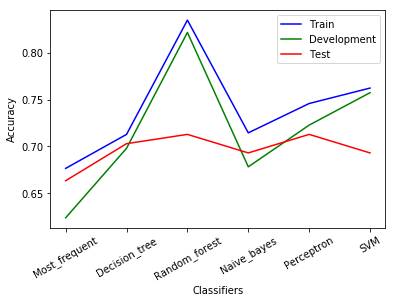

In [19]:
plot(classifiers, training_acc, 'b-',
     classifiers, dev_acc, 'g-',
     classifiers, test_acc, 'r-')
legend(('Train', 'Development', 'Test'))
xlabel('Classifiers')
ylabel('Accuracy')
xticks(rotation=30)
show()

As can be seen from the graph, all the models perform better than the baseline most frequent classifier on train, dev and test sets.<br />
Random forest performs the best on train, dev and test sets which is expected, it being an ensemble classifier.<br />
Multilayer perceptron performs as good as random forest on the test set.<br />
Both random forest and svm seem to perform poorly on the test set relative to their performance on the train and dev sets. This seems to indicate slight overfitting.